In [14]:
import math, pathlib, tempfile, os
import geopandas as gpd
import rasterio
import rasterio.plot as rioplt
import matplotlib.pyplot as plt
import shapely as shapely
import numpy as np
import pandas as pd
from rasterio.warp import calculate_default_transform

In [60]:
def printLists(listToPrint, maxLineLength=120, sep='||'):
    '''
    small function for printing list in a way that is a bit easier to read

    listToPrint {list}
    maxLineLength {int}:120
    sep {str}: '||'
    '''
    startSep = sep + ' '
    varSep = ' ' + sep + ' '
    lineToPrint = startSep

    for var in listToPrint:
        if len(var) + len(lineToPrint) + len(sep) + 2 <= maxLineLength:
            lineToPrint = lineToPrint + var + varSep
        else:
            print(lineToPrint)
            lineToPrint = startSep + var
    print(lineToPrint)


def printDictOfLists(dict, keys, maxLineLength=120, varSep='||', keySep='\n--------'):
    '''
    small function for printing list in a way that is a bit easier to read

    dict {dict}: expecting the values to be lists
    keys {list}: pass 1 or more keys in a list
    maxLineLength {int}:120
    varSep {str}: '||'
    keySep {str}: '\n--------'
    '''
    for key in keys:
        print(key, keySep)
        printLists(dict[key], maxLineLength=maxLineLength, sep=varSep)
        print('\n')


def printUnique(geodataframe, include:list=None, exclude:list=['gid', 'upid', 'geometry'], excludeNumeric:bool=True):
    '''
    small function to print out unique values in all columns or some columns.
    assumes you are passing it a GeoPandas dataframe so it will exclude some columns.

    '''
    if excludeNumeric:
        gdframe = geodataframe.select_dtypes(exclude='number')
    else:
        gdframe = geodataframe

    if include:
        catCols = [col for col in gdframe.columns.tolist() if col in include]
    else:
        catCols = [col for col in gdframe.columns.tolist() if col not in exclude]

    categoryDesc = dict()
    for key in catCols:
        categoryDesc[key] = gdframe[key].unique().tolist()

    printDictOfLists(categoryDesc, categoryDesc.keys())


def get_tmp_file(dir:[pathlib.Path, str]=None):
    '''Create and return a tmp filename, optionally at a specific path.
        `os.remove` when done with it.'''
    with tempfile.NamedTemporaryFile(delete=False, dir=dir) as f: return f.name


def bIfAisNone(a:any, b:any)->any:
    "return `a` if `a` is not none, otherwise return `b`."
    return b if a is None else a

# accessing coordinates
# #### maybe consider just using the geodataframe


# @dataclass
# class featureLoader():
#     ''' Binds featureLoader to GeoPandasDataframe'''
#     self.path = Path(path)
#     fd: gpd.read_file(self.path)
#     def __len__(self)->int: return len(self.fd)
#     def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
#     def __setstate__(self,data:Any): self.__dict__.update(data)

#     def describeCat(self, uniqueVals=True, include=None, exclude=None):
#         'print unique values of categorical (or object) type columns'
#         categCols = [col for col in bedrock_data.columns.tolist() if col not in ['gid', 'upid', 'area_m2', 'geometry']]
#         categoryDesc = dict()
#         for key in categCols:
#             categoryDesc[key] = bedrock_data[key].unique().tolist()
#         printDictOfLists(categoryDesc, ['rock_type', 'rock_class'])

#     def columnsPrint(self, maxLineLength=120)):
#         'print the column names in a slightly easier to read format'

#         printLists(self.columns.tolist(), maxLineLength=maxLineLength)

In [179]:
class PrepShapes():
    def __init__(self, data, shapeCategories:list, shapeNames:list, boundaryBuffer:int=10000):
        self.data=data
        if len(shapeCategories) > 1:
            if isinstance(shapeCategories, str):
                shapeCategories=list(shapeCategories)
            else:
                if len(shapeCategories) != len(shapeNames):
                    raise ValueError("shapeCategories must by a single cat or same size as shapeNames")
        self.shapeCategories:list=shapeCategories
        self.shapeNames:list=shapeNames
        self._nShapes=len(shapeNames)
        self.boundaryBuffer:int=boundaryBuffer
        self.dictOfProjShapes=dict()
        if len(self.shapeCategories) > 1:
            for cat, key in zip(self.shapeCategories, self.shapeNames):
                self.dictOfProjShapes[key] = {'cat': cat,
                                              'data': self.data.loc[self.data[cat] == key]}
                # self.dictProjShapes[key] = self.data.loc[self.data[cat] == key]
        else:
            for key in shapeNames:
                self.dictOfProjShapes[key] = {'cat': self.shapeCategories,
                                              'data': self.data.loc[self.data[self.shapeCategories] == key]}
        self._dissolved = False
        self._buffered = False
        self.projBounds = False

    def __setstate__(self, k): return getattr(self)

    def printUnique(self, include=None, exclude=['gid', 'upid', 'geometry'], excludeNumeric=True, maxLineLength=120):
        '''
        small function to print out unique values in all columns or some columns.
        assumes you are passing it a GeoPandas dataframe so it by default will exclude some columns.

        '''
        if excludeNumeric:
            gdframe = self.data.select_dtypes(exclude='number')
        else:
            gdframe = self.data

        if include:
            catCols = [col for col in gdframe.columns.tolist() if col in include]
        else:
            catCols = [col for col in gdframe.columns.tolist() if col not in exclude]

        categoryDesc = dict()
        for key in catCols:
            categoryDesc[key] = gdframe[key].unique().tolist()

        printDictOfLists(categoryDesc, categoryDesc.keys(), maxLineLength=maxLineLength)

    def printColumns(self, maxLineLength=120):
        'print the column names in a slightly easier to read format'

        printLists(self.data.columns.tolist(), maxLineLength=maxLineLength)

    def dissolveData(self, forceDissolve:bool=False):
        '''
        dissolve the many polygons within each shape into a single multipolygon
        
        forceDissolve:bool = force running dissolve again even if you already called it in the past.
        '''
        if forceDissolve or not self._dissolved:
            for key in self.shapeNames:
                column = self.dictOfProjShapes[key]['cat'] 
                dissolvedShape = self.dictOfProjShapes[key]['data'][[column, 'geometry']].dissolve(by=column,
                                                                                                   aggfunc='first',
                                                                                                   as_index=False)
                self.dictOfProjShapes[key].update({'dataDissolved': dissolvedShape})
            self._dissolved = True
        else:
            print('shapes already dissolved')

    def bufferData(self, buffer:int='default', addPercent=1.1):
        '''
        Create a buffered shape around the project shapes 
        '''
        if isinstance(buffer, str): 
            if buffer.lower() == 'default':
                buffer = self.boundaryBuffer
            else:
                raise ValueError(f"'default' or a value are the two currently supported buffer values. You passed:{buffer}")
        if addPercent:
            buffer = buffer * 1.1
        for key in self.shapeNames:
            dataToBuffer = 'dataDissolved' if self._dissolved else 'data'
            self.dictOfProjShapes[key].update({'buffer': self.dictOfProjShapes[key][dataToBuffer].buffer(buffer)})
        if not self._buffered:
            self._buffered = True

    def setBuffer(self, bufferSize=False):
        '''
        update the class boundary buffer variable
        '''
        if bufferSize:
            self.__dict__.update({'boundaryBuffer': bufferSize})

    def setProjectBoundary(self, buffer=True):
        '''
        this will need to be tested. trying to take
        '''
       # for key in self.dictOfProjShapes.keys():
        data = 'buffer' if buffer else 'data'
        minXList = [self.dictOfProjShapes[key][data].bounds.minx.values for key in self.dictOfProjShapes]
        maxXList = [self.dictOfProjShapes[key][data].bounds.maxx.values for key in self.dictOfProjShapes]
        minYList = [self.dictOfProjShapes[key][data].bounds.miny.values for key in self.dictOfProjShapes]
        maxYList = [self.dictOfProjShapes[key][data].bounds.maxy.values for key in self.dictOfProjShapes]

        minBounds = {'minx':max(minXList), 'miny':max(minYList), 
             'maxx':min(maxXList), 'maxy':min(maxYList)}
        self.__dict__.update({'projBounds': pd.DataFrame(minBounds)})

In [180]:
class RasterTemplate():
    '''
    initialize a raster template that will be used by the predictor class for creating the prediction and distance rasters
    '''
    def __init__(projBounds, cellWidthX, cellHeightY, crs, rasterDTypes='float32', transform='default', driver='GTiff'):
        self.projBounds:DataFrame = projBounds
        self.cellWidthX:np.number = cellWidthX
        self.cellHeightY:np.number = cellHeightY
        self.crs = rasterio.crs[crs]
        self.dtypes = rasterDTypes
        if isinstance(transform, str):
            if transform == 'default':
                self.transform = rasterio.transform.from_origin(projBounds.minx, projBounds.maxy, cellWidthX, cellHeightY)
            else:
                raise ValueError("currently only default transforms are supported. you can pass your own transform in a rasterio.transform format")
        self.data = None
        self._createEmptyRaster()
        self.driver = driver

    def initializeEmptyRaster(self):
        '''
        create an empty raster and set to self.data based on paramaters passed)
        '''
        minX = int(self.projBounds.bounds['minx'][0]) // self.cellWidthX * self.cellWidthX
        maxX = int(self.projBounds.bounds['maxx'][0]) // self.cellWidthX * self.cellWidthX
        minY = int(self.projBounds.bounds['miny'][0]) // self.cellHeightY * self.cellHeightY
        maxY = int(self.projBounds.bounds['maxy'][0]) // self.cellHeightY * self.cellHeightY

        xDim = maxX - minX
        yDim = maxY - minY
        nColsX = int(xDim / xRes)
        nRowsY = int(yDim / yRes)

        return np.full((nRowsY, nColsX), np.nan, dtype=self.dtypes)

# shape1_data:GeoDataFrame
    # shape2_data:GeoDataFrame
    # rasterDist1:np.array
    # rasterDist2:np.array
    # rasterProb:np.array

In [181]:
class PredictorByDistance():
    def __init__(self, preppedShape, rasterTemplate, architect='varriogram', archType='exponential', archRange=10000, modelDir='models'):
        self.shapes = preppedShape.dictProjShapes
        self.shapeKeys = self.shapes.keys()
        self.rasterTemplate = rasterTemplate
        self.predictRaster = rasterTemplate.initializeEmptyRaster()
        for key in preppedShape.dictProjShapes.keys():
            self.distRasters[key: rasterTemplate.initializeEmptyRaster()]
        self.architect = architect
        self.archType = archType
        self.archRange = archRange
        self.modelDir = modelDir

    def _testWriteablePath(self):
        '''test if you can write to path. makedir if needed'''
        if isinstance(self.modelDir, str):
            self.__dict__.update({'modelDir': pathlib.Path(self.modelDir)})
        try:
            path.mkdir(parents=True, exist_ok=True)
            tmpF = get_tmp_file(path)
        except OSError as e:
            raise Exception(f"{e}\nCan't write to '{path}', set `modelDir` attribute in predictor to a full libpath path that is writable") from None
        os.remove(tmp_file)

    def updateArchitect(self, architect=False, archType=False, archRange=False):

        if architect:
            self.__dict__.update({'architect': architect})
        if archType:
            self.__dict__.update({'archType': archType})
        if archRange:
            self.__dict__.update({'archRange': archRange})

    def distanceMatrix(self, maxRange=None, maxRangeMultiple=1.2):
        '''
        calculate the distance from center of each cell to the nearest boundary
        of the shape files. self.updateShapes() to change which shapes we are
        calculating distances to.

        example

        '''
        if maxRange:
            maxRange = maxRange
        elif maxRangeMultiple:
            maxRange = self.archRange * maxRangeMultiple
        else:
            maxRange = None

        for (idxR, idxC), sDist in np.ndenumerate(self.distRasters[self.shapeKeys[0]]):
            tmpPoint = shapely.geometry.Point(self.rasterTemplate.transform.xy(idxR, idxC))
            for key in self.shapeKeys:
                dist = self.shapes[key]['data'].distance(tmpPoint)
                if maxRange:
                    if dist <= maxRange:
                        self.distRasters[key][idxR][idxC] = dist
                else:
                    self.distRasters[key][idxR][idxC] = dist

    def predict(self, updateDistance:bool=True, distKwargs=None, varrioKwargs=None):
        '''
        updates distance matrix for each shape using self.distanceMatrix()
        Then calculated a weighted prediction using the pseudo varriogram. 
        This weights the predictions so that they drop to 0 when the range from either 
        of the shapes reaches the varriogram range.
        
        distKwargs:dict() = keyword arguments to pass to self.distanceMatrix
        varrioKwargs:dict() = keyword arguments to pass to self.varriogramExp
        '''
        if updateDistance:
            if distKwargs:
                self.distanceMatrix(**distKwargs)
            else:
                self.distanceMatrix()
        

        for (idxR, idxC), _ in np.ndenumerate(self.predictRaster):
            distances = list()
            for key in self.shapeKeys:
                distances.append(self.distRasters[key][idxR][idxC])
            prediction = self.varriogramExp(distances, vRange)
            self.predictRaster[idxR][idxC] = prediction

    def varriogramExp(self, distList, varrioRange='default', distFactor=1.5, smoothFactor=1):
        '''
        use a pseudo varriogram for calculating a weighted prediction. this gives you a
        smooth prediction from 1 (most likely) to 0 (least likely) based on the distance to the 
        shapes. It drops off to nearly zero once the distance to any of the shapes reaches the 
        varriogram range. 
        
        Note: works well with 2 distances... more distances will mean it will
        take a little longer to drop to near zero if the distance to only 1 shape reaches the 
        range.

        varrioRange:[int, float]= by default uses self.archRange but can change to a new range.
        distFactor:[int, float]=1.5 - the larger the number the steeper the change
        smoothFactor:[int, float]=1 - the larger the number the shallower the change

        prediction calculated from 2 distances and default values:
        distFactor=1.5, smoothFactor=1

        predict = 1 * math.exp( -((1.5 * dist1)**2/varrioRange**2) -((1.5 * dist2)**2/varrioRange**2) )


        '''
        # determine if we are using the default varriogram/architect range or a new range
        if isinstance(varrioRange, str):
            if varrioRange.lower() == 'default':
                vRange = self.archRange
            else:
                raise ValueError("either pass numeric range or `default`")
        else:
            vRange = varrioRange
        # calculate the weighted prediction
        power = list()
        for d in distList:
            power.append(calcPower(dist, vRange, distFact))
        power = sum(power)

        return smoothFactor * math.exp(power)

    def calcPower(dist, archRange, distFact):
        '''
        return the distance factor used in varriogram exponential calculation
        '''
        return -((distFact * dist)**2/archRange**2)

    def saveRaster(self, file:[pathlib.Path,str]=None, bands:str='prediction'):
        '''
        save the prediction and/or distance rasters to file using the GTiff driver
        file:[Path, str] = path to save file to. Will use model directory set in class
        bands:str = options include 'all', 'prediction', or 'distances'

        '''
        if self.modelDir: self._testWriteablePath()
            
        if isinstance(file, [pathlib.Path, str]):
            target = self.modelDir/file 
        else:
            file
            
        bands = bands.lower()
        if bands == 'all':
            targets = {'pred_'/target: self.predictRaster}
            for key in self.shapeKeys:
                targets[key/'_'/target] = self.distRaster[key]
        elif bands == 'prediction':
            targets = {'pred_'/target: self.predictRaster}
        elif bands == 'distances':
            targets = dict()
            for key in self.shapeKeys:
                targets[key/'_'/target] = self.distRaster[key]
        else:
            raise ValueError("only currently supported save options are bands = 'all', 'predictions' OR 'distances'")

        for flKey in targets.keys:
            with rasterio.open(flKey, 'w', driver='GTiff',
                               height=self.rasterTemplate.cellHeightY,
                               width=self.rasterTemplate.cellWidthX,
                               count=1, dtype=self.rasterTemplate.dtypes,
                               crs=self.rasterTemplate.crs, transform=self.rasterTemplate.transform) as sRaster:
                sRaster.write(targets[flKey], 1)


    def loadRaster(self, path:[pathlib.Path, str], rasterType:str='prediction'):
        '''
        load a prediction raster that has been previously saved.
        '''
        
        if isinstance(path, str): pathlib.Path(path)
        possiblePaths = [path, path.with_suffix('tiff'), path.with_name('pred_'/path.name), 
                         path.with_name('pred_'/path.name).with_suffix('tiff')]
        idx = 0
        while idx < len(possiblePaths):
            if possiblePaths[idx].exists(): 
                target = possiblePaths[idx]
                break
            i += 1
        else:
            raise ValueError(f"raster path:{path} not found")

        rasterType = rasterType.lower()
        if rasterType =='prediction':
            self.predictRaster = rasterio.open(target).read(1)
        else:
            raise ValueError("haven't implemented reading in the distance raster(s) yet")

In [182]:
INPUT_FILE = "data/BedrockP.shp"
bedrockData = gpd.read_file(INPUT_FILE)

In [183]:
bedrockData.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 126°W to 120°W and NAD83 by country
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [184]:
prepData = PrepShapes(bedrockData, shapeCategories=['rock_type', 'rock_class'], 
                        shapeNames=['granodioritic intrusive rocks', 'ultramafic rocks'])

In [185]:
prepData.printColumns(maxLineLength=60)

|| gid || upid || area_m2 || strat_unit || era || period || 
|| strat_agestrat_name || gp_suite || fm_lithodm || 
|| mem_phaserock_class || rock_type || rk_char || 
|| unit_descage_max || age_min || belt || terrane || 
|| basinbasin_age || project || src_url || src_ref_s || 
|| map_compedit_date || pub_org || geometry || 


In [186]:
prepData.printUnique(include=['rock_class', 'rock_type'], maxLineLength=100)

rock_class 
--------
|| volcanic rocks || sedimentary rocks || intrusive rocks || ultramafic rocks || 
|| metamorphic rocks


rock_type 
--------
|| coarse volcaniclastic and pyroclastic volcanic rocks || marine sedimentary and volcanic rocks || 
|| mudstone, siltstone, shale fine clastic sedimentary rocksbasaltic volcanic rocks || 
|| undivided sedimentary rocksandesitic volcanic rocks || feldspar porphyritic intrusive rocks || 
|| granodioritic intrusive rocksultramafic rocks || quartz dioritic intrusive rocks || 
|| granite, alkali feldspar granite intrusive rocksserpentinite ultramafic rocks || 
|| coarse clastic sedimentary rocksundivided volcanic rocks || dioritic intrusive rocks || 
|| greenstone, greenschist metamorphic rocksorthogneiss metamorphic rocks || 
|| argillite, greywacke, wacke, conglomerate turbiditesquartz monzonitic intrusive rocks || 
|| calc-alkaline volcanic rocksmid amphibolite/andalusite grade metamorphic rocks || 
|| rhyolite, felsic volcanic rocksconglomera

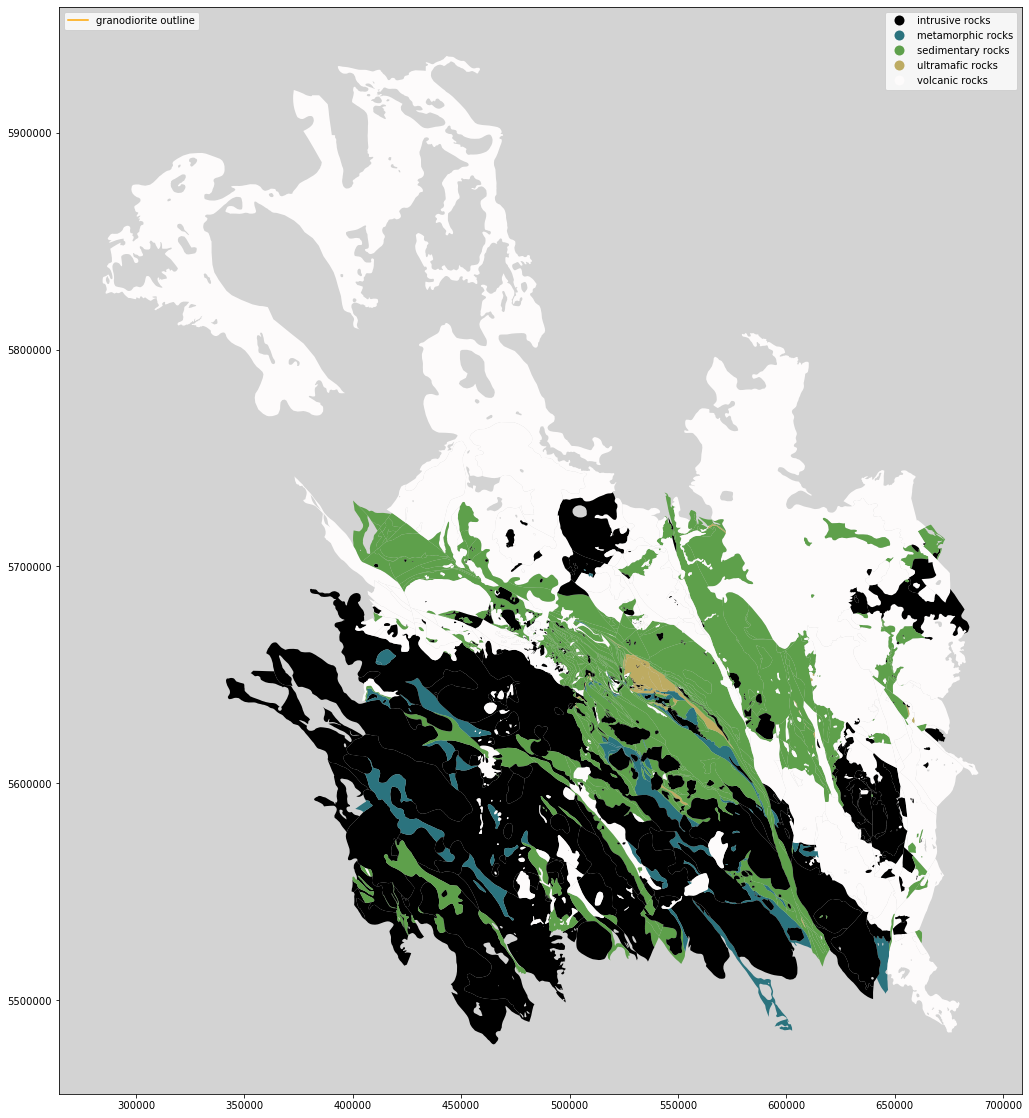

In [187]:
fig, ax = plt.subplots(figsize=(20,20))
prepData.data.plot(column="rock_class", categorical=True, legend=True,
                           ax=ax, cmap='gist_earth')
# granodioriteData.plot(categorical=True, legend=False,
#                       ax=ax, color='none', edgecolor='orange')
from matplotlib.legend import Legend
granoleg = ax.plot([], color='orange')
leg = Legend(ax, granoleg, ['granodiorite outline'],
             loc='upper left', frameon=True)
ax.add_artist(leg)
ax.set_facecolor('lightgrey')

In [188]:
prepData.dissolveData()

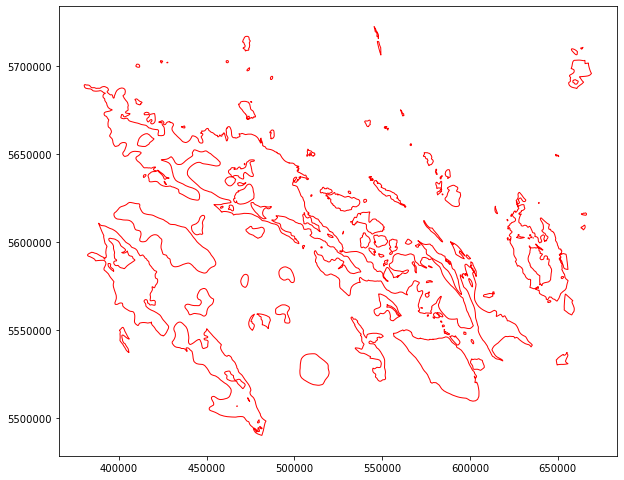

In [189]:
fig, ax = plt.subplots(figsize=(10, 10))
prepData.dictOfProjShapes['granodioritic intrusive rocks']['dataDissolved'].plot(categorical=True, legend=True,
                                                                                 ax=ax, facecolor='none', 
                                                                                 edgecolor='r')

In [190]:
prepData.bufferData()

In [192]:
prepData.setProjectBoundary()
prepData.projBounds

,minx,miny,maxx,maxy
0,491522.194408,5.522125e+06,670103.434455,5.730940e+06
